In [1]:
# !pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost  import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import KFold, cross_validate,  train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
import optuna
from tqdm import tqdm
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

In [3]:
url = 'https://raw.githubusercontent.com/suxeno/StudyDateAI-Week1-Evaluation-Dataset/refs/heads/main/portugal-housing-sample.csv'
data = pd.read_csv(url)

In [4]:
df = data.copy(deep=True)

In [5]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Floor,Lift,Parking,HasParking,...,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,55000.0,Coimbra,Figueira da Foz,Alqueidão,Land,NC,NaN,False,0.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1287.0,NaN,NaN,0.0
1,289000.0,Setúbal,Montijo,Canha,House,D,NaN,False,2.0,True,...,NaN,NaN,4.0,NaN,NaN,NaN,156.0,NaN,NaN,4.0
2,46500.0,Lisboa,Lourinhã,Lourinhã e Atalaia,Land,NC,NaN,NaN,0.0,NaN,...,False,False,NaN,NaN,0.0,NaN,NaN,2880.0,NaN,0.0
3,203000.0,Porto,Vila Nova de Gaia,Vilar de Andorinho,Apartment,E,3rd Floor,True,1.0,True,...,NaN,NaN,2.0,NaN,NaN,NaN,92.0,NaN,NaN,2.0
4,72500.0,Braga,Cabeceiras de Basto,"Refojos de Basto, Outeiro e Painzela",Land,NC,NaN,NaN,0.0,NaN,...,False,False,NaN,NaN,0.0,NaN,NaN,1954.0,NaN,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 20000 non-null  float64
 1   District              20000 non-null  object 
 2   City                  20000 non-null  object 
 3   Town                  19999 non-null  object 
 4   Type                  20000 non-null  object 
 5   EnergyCertificate     20000 non-null  object 
 6   Floor                 4925 non-null   object 
 7   Lift                  11874 non-null  object 
 8   Parking               19967 non-null  float64
 9   HasParking            11874 non-null  object 
 10  ConstructionYear      12965 non-null  float64
 11  TotalArea             18941 non-null  float64
 12  GrossArea             4790 non-null   float64
 13  PublishDate           2668 non-null   object 
 14  Garage                8123 non-null   object 
 15  Elevator           

# Exploratory Data Analysis

## Missing Value

In [7]:
df.isna().sum()

Price                       0
District                    0
City                        0
Town                        1
Type                        0
EnergyCertificate           0
Floor                   15075
Lift                     8126
Parking                    33
HasParking               8126
ConstructionYear         7035
TotalArea                1059
GrossArea               15210
PublishDate             17332
Garage                  11877
Elevator                11877
ElectricCarsCharging    11877
TotalRooms               8564
NumberOfBedrooms        14636
NumberOfWC              12695
ConservationStatus      17673
LivingArea               4690
LotSize                 14944
BuiltArea               16737
NumberOfBathrooms         877
dtype: int64

In [8]:
df.isna().mean()*100

Price                    0.000
District                 0.000
City                     0.000
Town                     0.005
Type                     0.000
EnergyCertificate        0.000
Floor                   75.375
Lift                    40.630
Parking                  0.165
HasParking              40.630
ConstructionYear        35.175
TotalArea                5.295
GrossArea               76.050
PublishDate             86.660
Garage                  59.385
Elevator                59.385
ElectricCarsCharging    59.385
TotalRooms              42.820
NumberOfBedrooms        73.180
NumberOfWC              63.475
ConservationStatus      88.365
LivingArea              23.450
LotSize                 74.720
BuiltArea               83.685
NumberOfBathrooms        4.385
dtype: float64

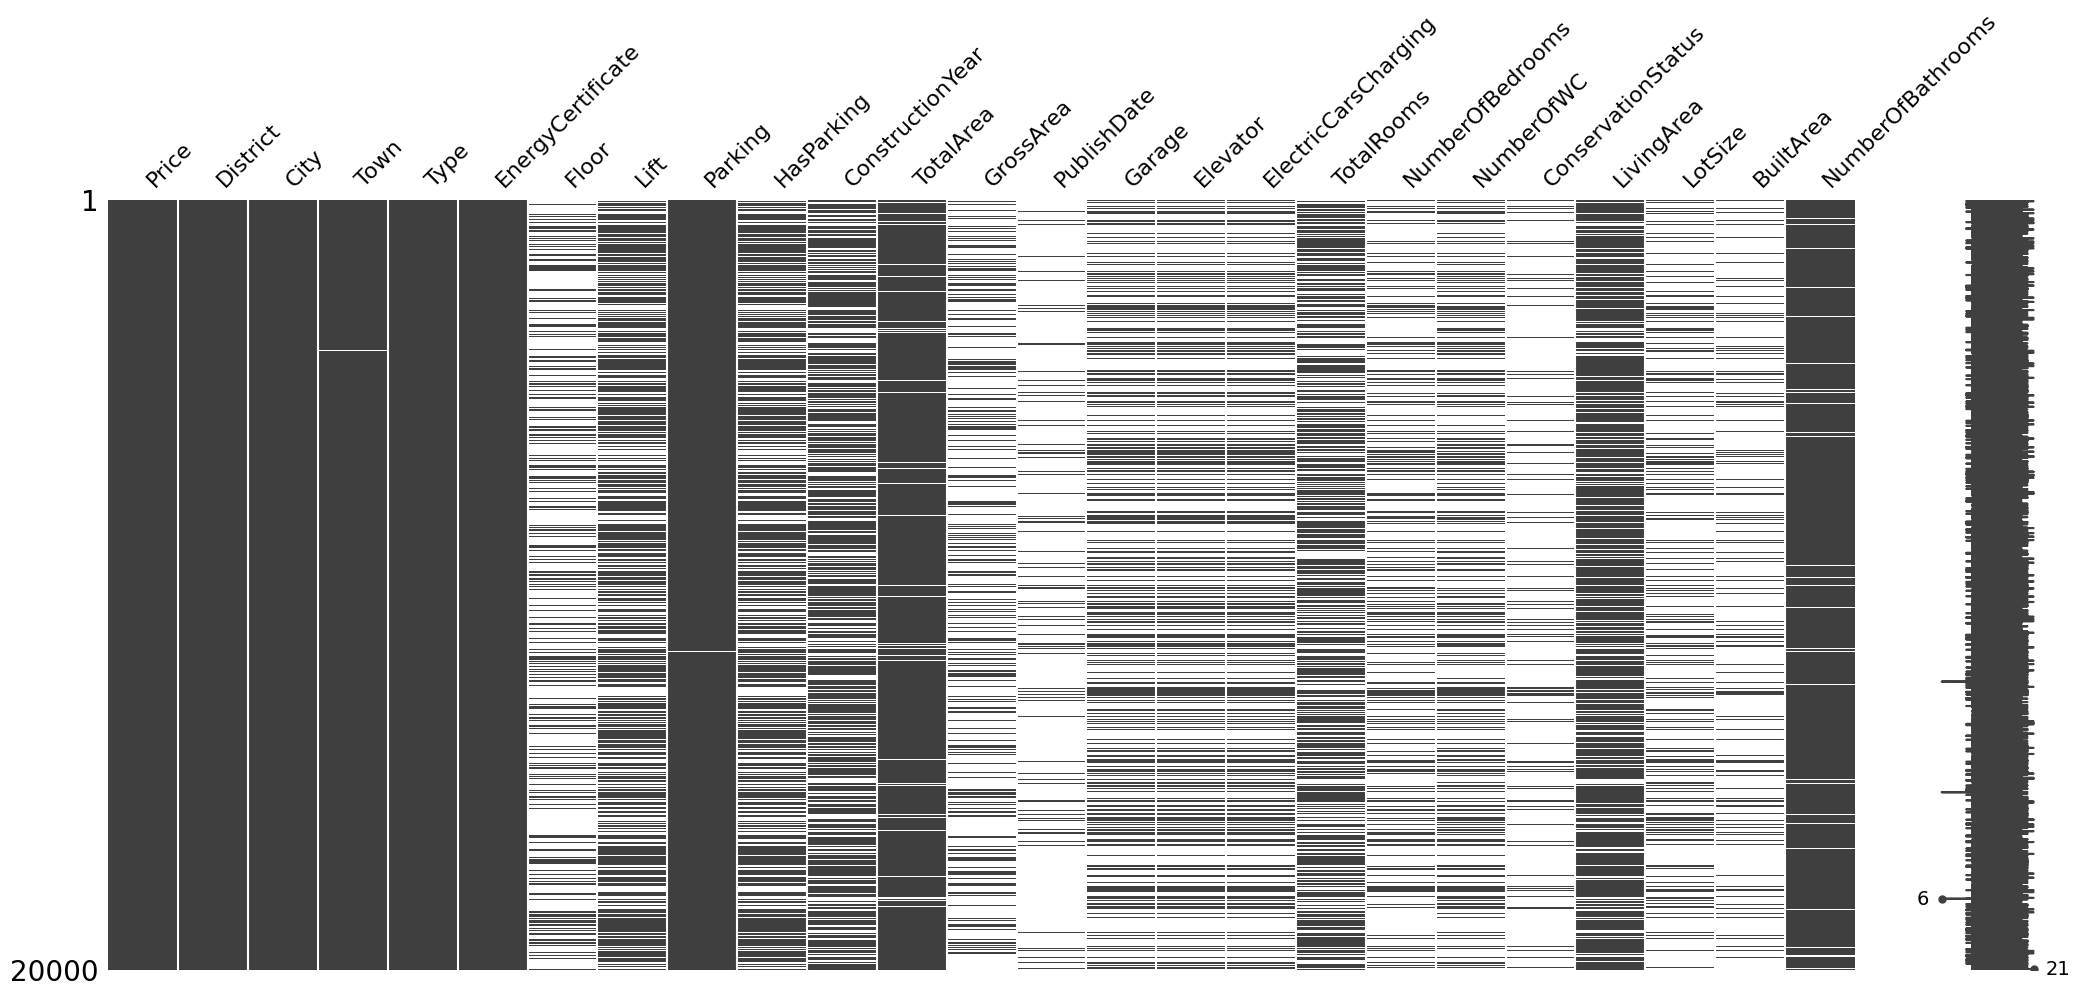

In [9]:
msno.matrix(df)
plt.show()

In [10]:
drop_columns = df.columns[df.apply(lambda x: x.isna().mean() > 0.8)]
drop_columns

Index(['PublishDate', 'ConservationStatus', 'BuiltArea'], dtype='object')

In [11]:
df.drop(columns=drop_columns, inplace=True)
df.shape

(20000, 22)

In [12]:
df_char = df.select_dtypes(include='object').columns
df_char

Index(['District', 'City', 'Town', 'Type', 'EnergyCertificate', 'Floor',
       'Lift', 'HasParking', 'Garage', 'Elevator', 'ElectricCarsCharging'],
      dtype='object')

In [13]:
df[df_char].nunique()

District                  24
City                     264
Town                    1869
Type                      21
EnergyCertificate         11
Floor                     18
Lift                       2
HasParking                 2
Garage                     2
Elevator                   2
ElectricCarsCharging       2
dtype: int64

In [14]:
for i in df_char:
    print(f"Columns of {i}: {len(df[i].unique())}")
    print(df[i].unique())
    print()

Columns of District: 24
['Coimbra' 'Setúbal' 'Lisboa' 'Porto' 'Braga' 'Évora' 'Leiria' 'Faro'
 'Aveiro' 'Bragança' 'Vila Real' 'Castelo Branco' 'Viana do Castelo'
 'Portalegre' 'Santarém' 'Guarda' 'Beja' 'Ilha de Porto Santo'
 'Ilha Terceira' 'Viseu' 'Ilha de Santa Maria' 'Ilha da Madeira'
 'Z - Fora de Portugal' 'Ilha de São Miguel']

Columns of City: 264
['Figueira da Foz' 'Montijo' 'Lourinhã' 'Vila Nova de Gaia'
 'Cabeceiras de Basto' 'Cascais' 'Reguengos de Monsaraz' 'Porto de Mós'
 'São Brás de Alportel' 'Celorico de Basto' 'Oliveira de Azeméis'
 'Odivelas' 'Bragança' 'Penafiel' 'Évora' 'Mafra' 'Arraiolos' 'Lisboa'
 'Caldas da Rainha' 'Loures' 'Porto' 'Setúbal' 'Sesimbra'
 'Vila Franca de Xira' 'Oeiras' 'Albufeira' 'Alijó' 'Felgueiras' 'Sertã'
 'Coimbra' 'Maia' 'Portimão' 'Braga' 'Vila Nova de Famalicão' 'Barreiro'
 'Paredes' 'Cadaval' 'Marco de Canaveses' 'Viana do Castelo' 'Alenquer'
 'Almada' 'Ponte da Barca' 'Portalegre' 'Chaves' 'Alcobaça'
 'Póvoa de Varzim' 'Vila Real' 'Mato

In [15]:
df['Floor'] = df['Floor'].replace({'Basement':'Basement Level', 'Attic':'Top Floor'})

In [16]:
df['EnergyCertificate'] = df['EnergyCertificate'].replace({'Not available':np.nan})

In [17]:
for i in df_char:
    print(f"Columns of {i}: {len(df[i].unique())}")
    print(df[i].unique())
    print()

Columns of District: 24
['Coimbra' 'Setúbal' 'Lisboa' 'Porto' 'Braga' 'Évora' 'Leiria' 'Faro'
 'Aveiro' 'Bragança' 'Vila Real' 'Castelo Branco' 'Viana do Castelo'
 'Portalegre' 'Santarém' 'Guarda' 'Beja' 'Ilha de Porto Santo'
 'Ilha Terceira' 'Viseu' 'Ilha de Santa Maria' 'Ilha da Madeira'
 'Z - Fora de Portugal' 'Ilha de São Miguel']

Columns of City: 264
['Figueira da Foz' 'Montijo' 'Lourinhã' 'Vila Nova de Gaia'
 'Cabeceiras de Basto' 'Cascais' 'Reguengos de Monsaraz' 'Porto de Mós'
 'São Brás de Alportel' 'Celorico de Basto' 'Oliveira de Azeméis'
 'Odivelas' 'Bragança' 'Penafiel' 'Évora' 'Mafra' 'Arraiolos' 'Lisboa'
 'Caldas da Rainha' 'Loures' 'Porto' 'Setúbal' 'Sesimbra'
 'Vila Franca de Xira' 'Oeiras' 'Albufeira' 'Alijó' 'Felgueiras' 'Sertã'
 'Coimbra' 'Maia' 'Portimão' 'Braga' 'Vila Nova de Famalicão' 'Barreiro'
 'Paredes' 'Cadaval' 'Marco de Canaveses' 'Viana do Castelo' 'Alenquer'
 'Almada' 'Ponte da Barca' 'Portalegre' 'Chaves' 'Alcobaça'
 'Póvoa de Varzim' 'Vila Real' 'Mato

## Label Encoding

In [18]:
lb_encoder = LabelEncoder()
cols = ['Lift', 'HasParking', 'Garage', 'Elevator', 'ElectricCarsCharging']

for i in cols:
    df[i] = lb_encoder.fit_transform(df[i])

In [19]:
te_encoder = TargetEncoder(smoothing=0.5)
cols = ['City', 'District', 'Town', 'Type']

for i in cols:
    df[i] = te_encoder.fit_transform(df[i], df['Price'])

In [20]:
oh_encoder = OneHotEncoder(sparse_output=False)

encoded = oh_encoder.fit_transform(df[['EnergyCertificate']])
df_encoded = pd.DataFrame(data=encoded, columns=oh_encoder.get_feature_names_out())

In [21]:
df.drop('EnergyCertificate', axis=1, inplace=True)
df = pd.concat([df, df_encoded], axis=1)

In [22]:
df['Floor'] = df['Floor'].map({
    'Basement Level': 0,
    'Ground Floor': 1,
    '1st Floor': 2,
    '2nd Floor': 3, 
    '3rd Floor': 4,
    '4th Floor': 5,
    '5th Floor': 6,
    '6th Floor': 7,
    '7th Floor': 8,
    '8th Floor': 9,
    '9th Floor': 10,
    'Above 10th Floor': 11,
    'Top Floor': 12,
    'Service Floor': 13,
    'Triplex': 14,
    'Duplex':15,
})

In [23]:
df.describe()

,Price,District,City,Town,Type,Floor,Lift,Parking,HasParking,ConstructionYear,...,EnergyCertificate_A+,EnergyCertificate_B,EnergyCertificate_B-,EnergyCertificate_C,EnergyCertificate_D,EnergyCertificate_E,EnergyCertificate_F,EnergyCertificate_G,EnergyCertificate_NC,EnergyCertificate_nan
count,2.000000e+04,20000.000000,2.000000e+04,2.000000e+04,2.000000e+04,4925.000000,20000.000000,19967.000000,20000.000000,12965.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.00000,20000.000000
mean,3.604319e+05,360526.878267,3.667826e+05,4.138957e+05,3.557073e+05,3.073706,0.963200,0.580508,1.080600,1988.743000,...,0.032700,0.031450,0.033900,0.115950,0.113850,0.08385,0.05720,0.003600,0.45770,0.000150
std,6.820353e+05,158395.831937,2.162299e+05,2.144149e+05,1.450141e+05,2.383187,0.920917,0.882576,0.851786,26.716358,...,0.177855,0.174535,0.180976,0.320173,0.317637,0.27717,0.23223,0.059893,0.49822,0.012247
min,1.000000e+02,94694.863962,2.886167e+04,2.885110e+04,3.867805e+04,0.000000,0.000000,0.000000,0.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000
25%,7.950000e+04,231912.855433,2.067240e+05,3.507700e+05,1.989455e+05,1.000000,0.000000,0.000000,0.000000,1972.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000
50%,2.000000e+05,354395.628585,3.253279e+05,3.604319e+05,3.765384e+05,3.000000,1.000000,0.000000,1.000000,1993.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000
75%,3.900000e+05,546627.963016,4.649349e+05,4.181592e+05,4.134490e+05,4.000000,2.000000,1.000000,2.000000,2008.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.00000,0.000000
max,3.600000e+07,579375.321059,1.088814e+06,1.731673e+06,1.778566e+06,15.000000,2.000000,3.000000,2.000000,2024.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.00000,1.000000


## Imputation of Missing Value

In [24]:
cbr = CatBoostRegressor(iterations=10, learning_rate=0.01, loss_function='RMSE', depth=10, one_hot_max_size=10)
imputer = IterativeImputer(estimator=cbr, max_iter=10, verbose=2, random_state=42)

df_imputed = imputer.fit_transform(df)

[IterativeImputer] Completing matrix with shape (20000, 32)
0:	learn: 679662.5268740	total: 185ms	remaining: 1.67s
1:	learn: 677426.3651279	total: 229ms	remaining: 917ms
2:	learn: 675045.5156095	total: 273ms	remaining: 637ms
3:	learn: 672798.3244637	total: 316ms	remaining: 474ms
4:	learn: 670756.7631276	total: 357ms	remaining: 357ms
5:	learn: 668549.7783919	total: 400ms	remaining: 267ms
6:	learn: 666377.6431578	total: 443ms	remaining: 190ms
7:	learn: 664015.0866686	total: 487ms	remaining: 122ms
8:	learn: 661773.4270815	total: 529ms	remaining: 58.8ms
9:	learn: 659645.2708993	total: 572ms	remaining: 0us
0:	learn: 157396.2156734	total: 52.1ms	remaining: 468ms
1:	learn: 156339.8368443	total: 98.5ms	remaining: 394ms
2:	learn: 155282.1155993	total: 143ms	remaining: 334ms
3:	learn: 154241.6948219	total: 188ms	remaining: 283ms
4:	learn: 153250.1816053	total: 234ms	remaining: 234ms
5:	learn: 152260.0246444	total: 281ms	remaining: 188ms
6:	learn: 151373.4407229	total: 327ms	remaining: 140ms
7:	l

In [25]:
df = pd.DataFrame(df_imputed,columns=df.columns)
df.head()

,Price,District,City,Town,Type,Floor,Lift,Parking,HasParking,ConstructionYear,...,EnergyCertificate_A+,EnergyCertificate_B,EnergyCertificate_B-,EnergyCertificate_C,EnergyCertificate_D,EnergyCertificate_E,EnergyCertificate_F,EnergyCertificate_G,EnergyCertificate_NC,EnergyCertificate_nan
0,55000.0,182976.679530,181476.439216,360431.935990,198945.468485,2.890121,0.0,0.0,0.0,1988.610505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,289000.0,438320.075269,433717.454545,360431.935990,413449.025698,3.054137,0.0,2.0,1.0,1986.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,46500.0,579375.321059,383077.451923,507618.867925,198945.468485,3.070403,2.0,0.0,2.0,1988.128326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,203000.0,354395.628585,420628.237988,350485.967995,376538.433345,4.000000,1.0,1.0,1.0,1996.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,72500.0,246906.372279,175244.339623,193420.501695,198945.468485,3.043777,2.0,0.0,2.0,1988.311230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


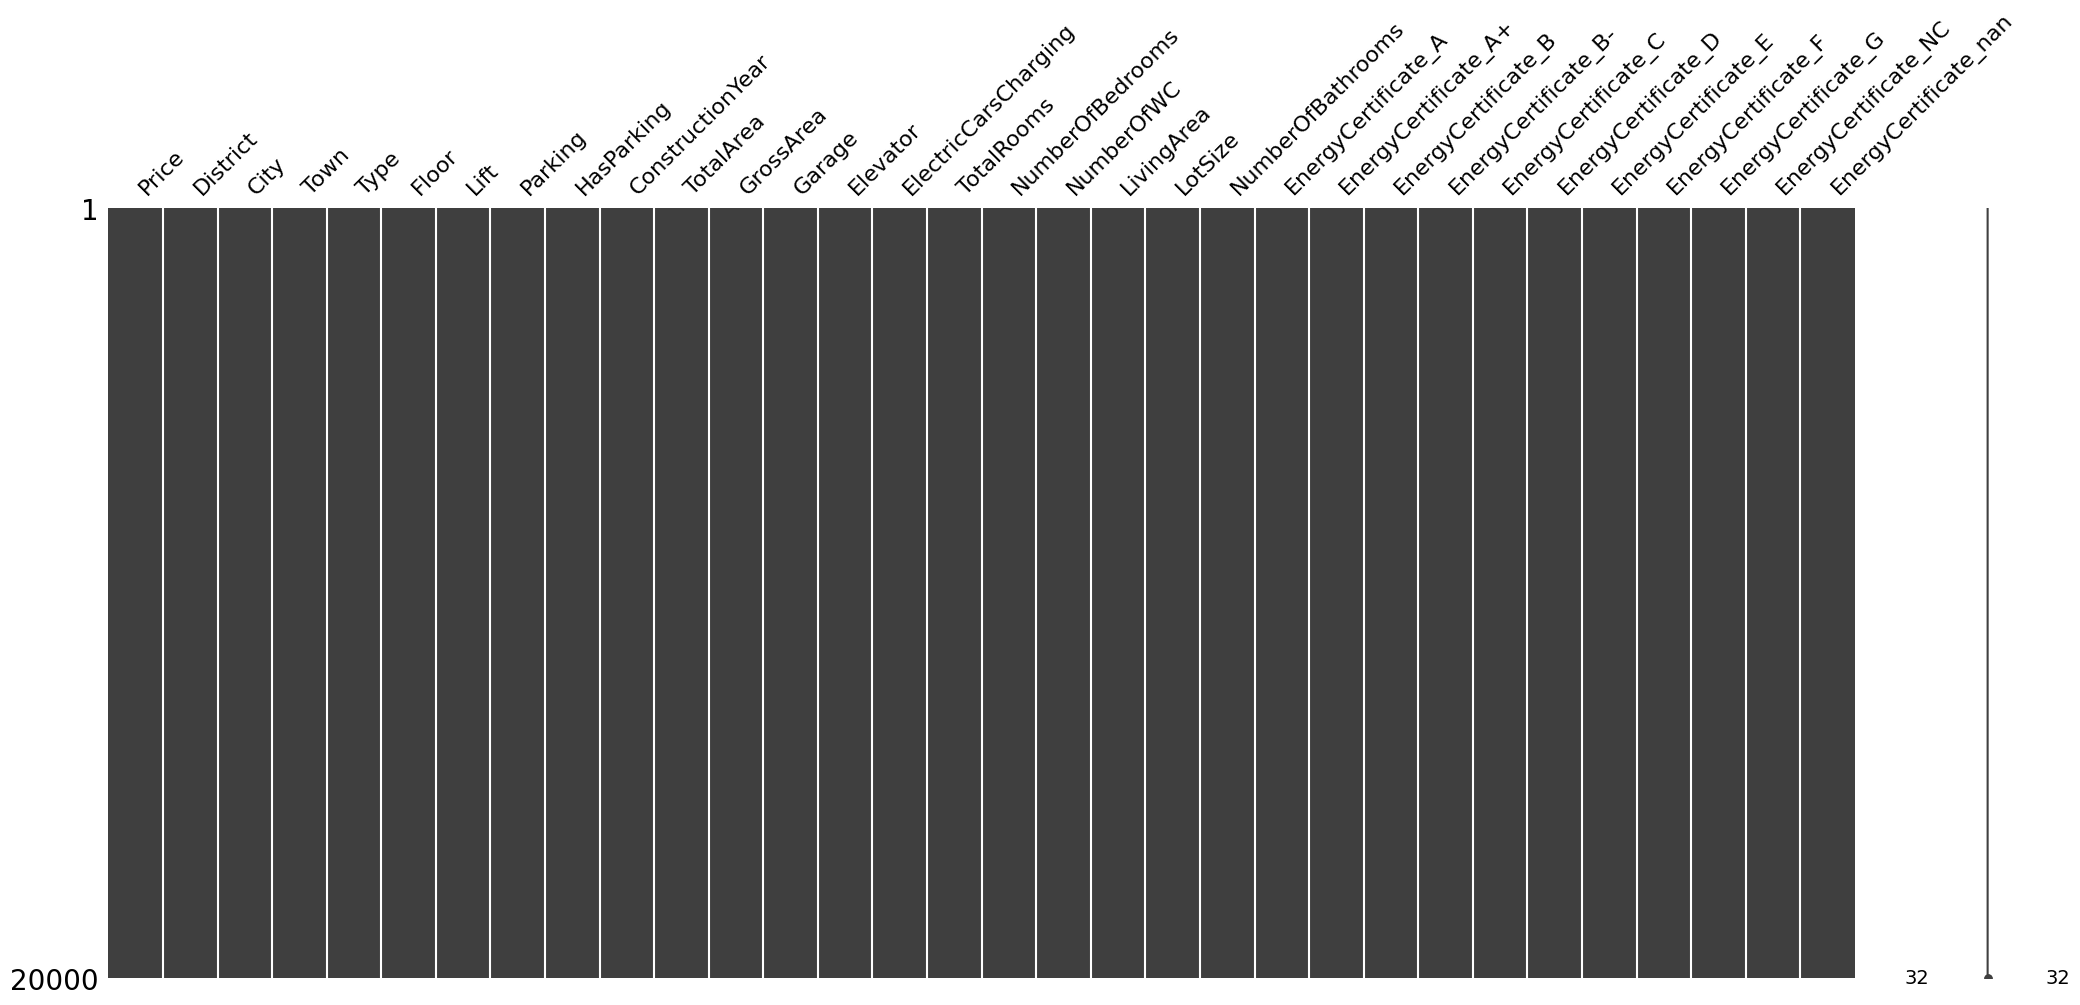

In [26]:
msno.matrix(df)
plt.show()

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,20000.0,360431.935990,6.820353e+05,100.000000,79500.000000,200000.000000,390000.000000,3.600000e+07
District,20000.0,360526.878267,1.583958e+05,94694.863962,231912.855433,354395.628585,546627.963016,5.793753e+05
City,20000.0,366782.569672,2.162299e+05,28861.667350,206723.964497,325327.927928,464934.917800,1.088814e+06
Town,20000.0,413895.736721,2.144149e+05,28851.096867,350770.000000,360431.935990,418159.211257,1.731673e+06
Type,20000.0,355707.295356,1.450141e+05,38678.045113,198945.468485,376538.433345,413449.025698,1.778566e+06
Floor,20000.0,3.052705,1.185385e+00,0.000000,2.926720,3.044008,3.119337,1.500000e+01
Lift,20000.0,0.963200,9.209170e-01,0.000000,0.000000,1.000000,2.000000,2.000000e+00
Parking,20000.0,0.580738,8.818671e-01,0.000000,0.000000,0.000000,1.000000,3.000000e+00
HasParking,20000.0,1.080600,8.517863e-01,0.000000,0.000000,1.000000,2.000000,2.000000e+00
ConstructionYear,20000.0,1988.816426,2.152211e+01,1900.000000,1986.000000,1988.636325,2000.000000,2.024000e+03


# Data Visualization

In [28]:
viz_column = ['Price', 'District', 'City', 'Town', 'Type', 'Floor', 'Lift', 'Parking',
       'HasParking', 'ConstructionYear', 'TotalArea', 'GrossArea', 'Garage',
       'Elevator', 'ElectricCarsCharging', 'TotalRooms', 'NumberOfBedrooms',
       'NumberOfWC', 'LivingArea', 'LotSize', 'NumberOfBathrooms']

print(len(viz_column))

21


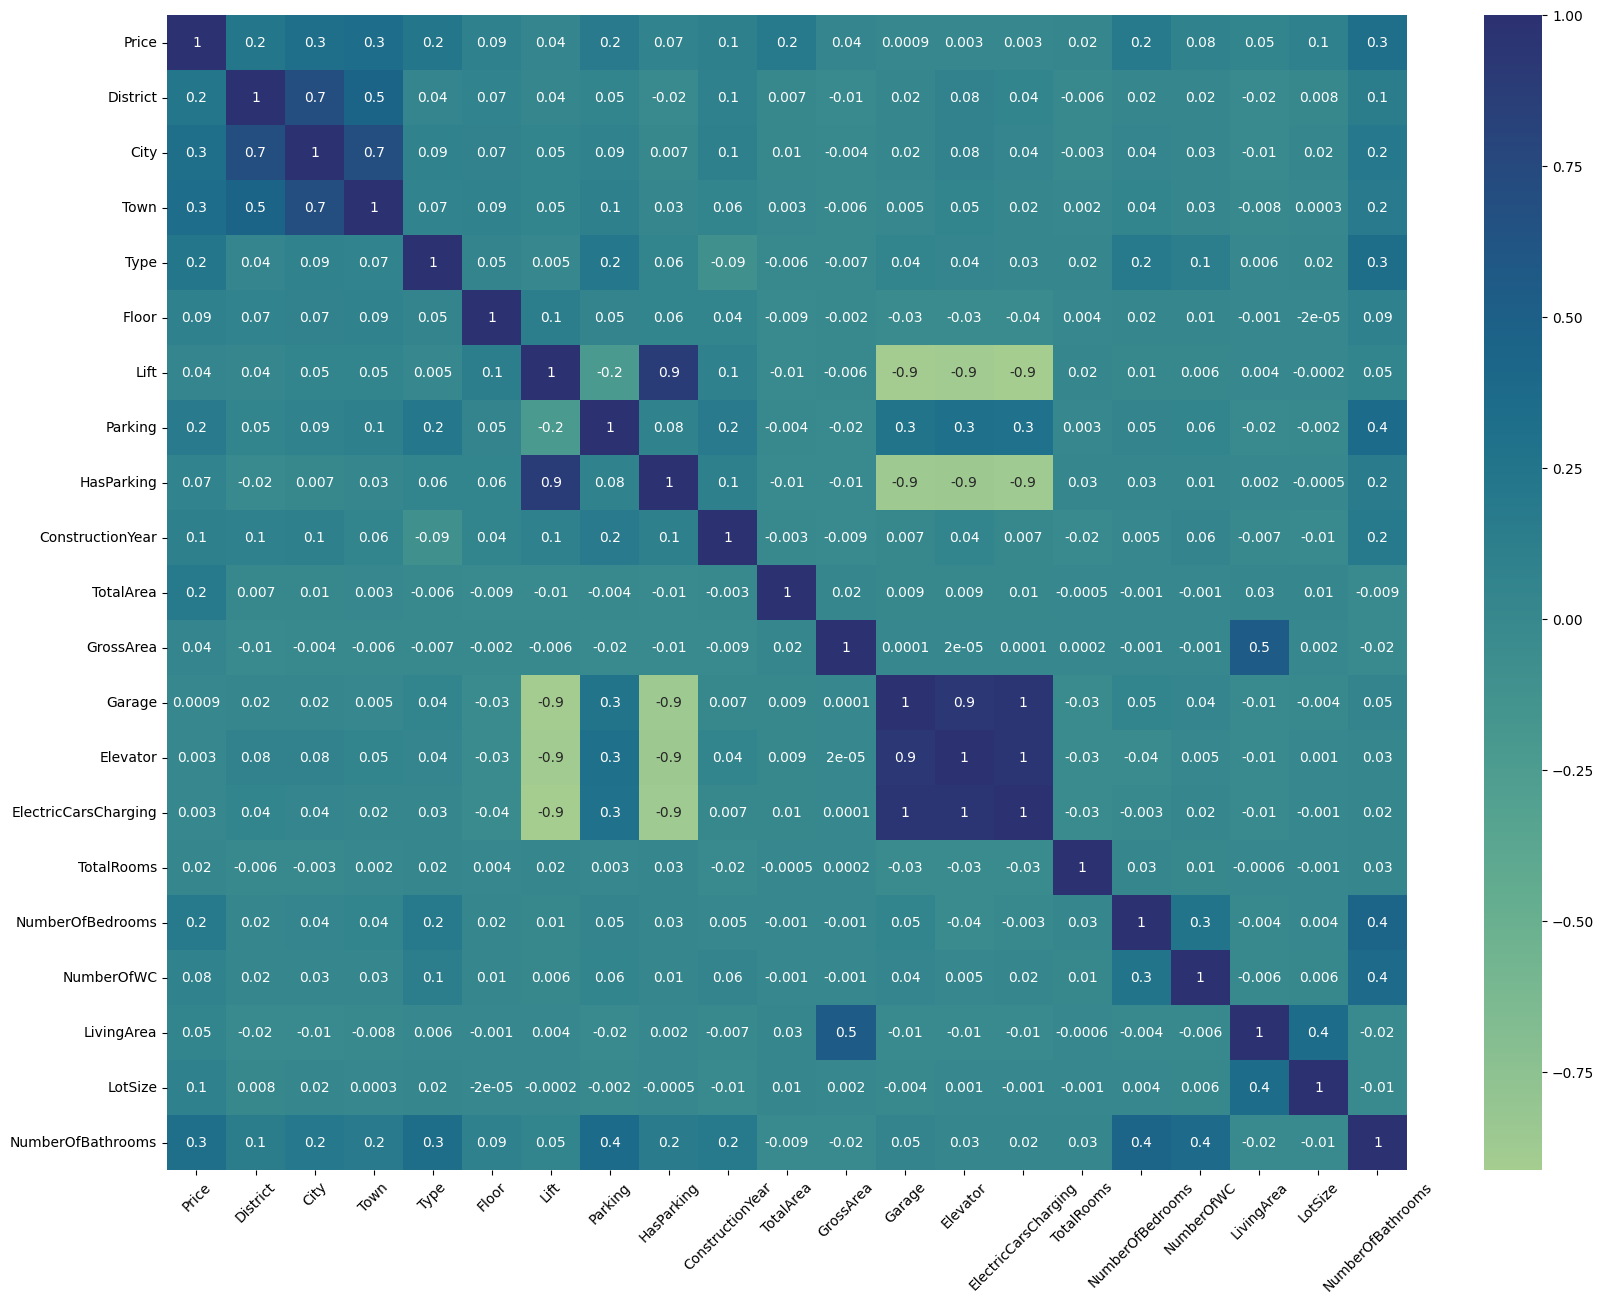

In [29]:
plt.figure(figsize=(20, 15))
sns.heatmap(df[viz_column].corr(), annot=True, cmap='crest', fmt='.1g')
plt.xticks(rotation=45)
plt.show()

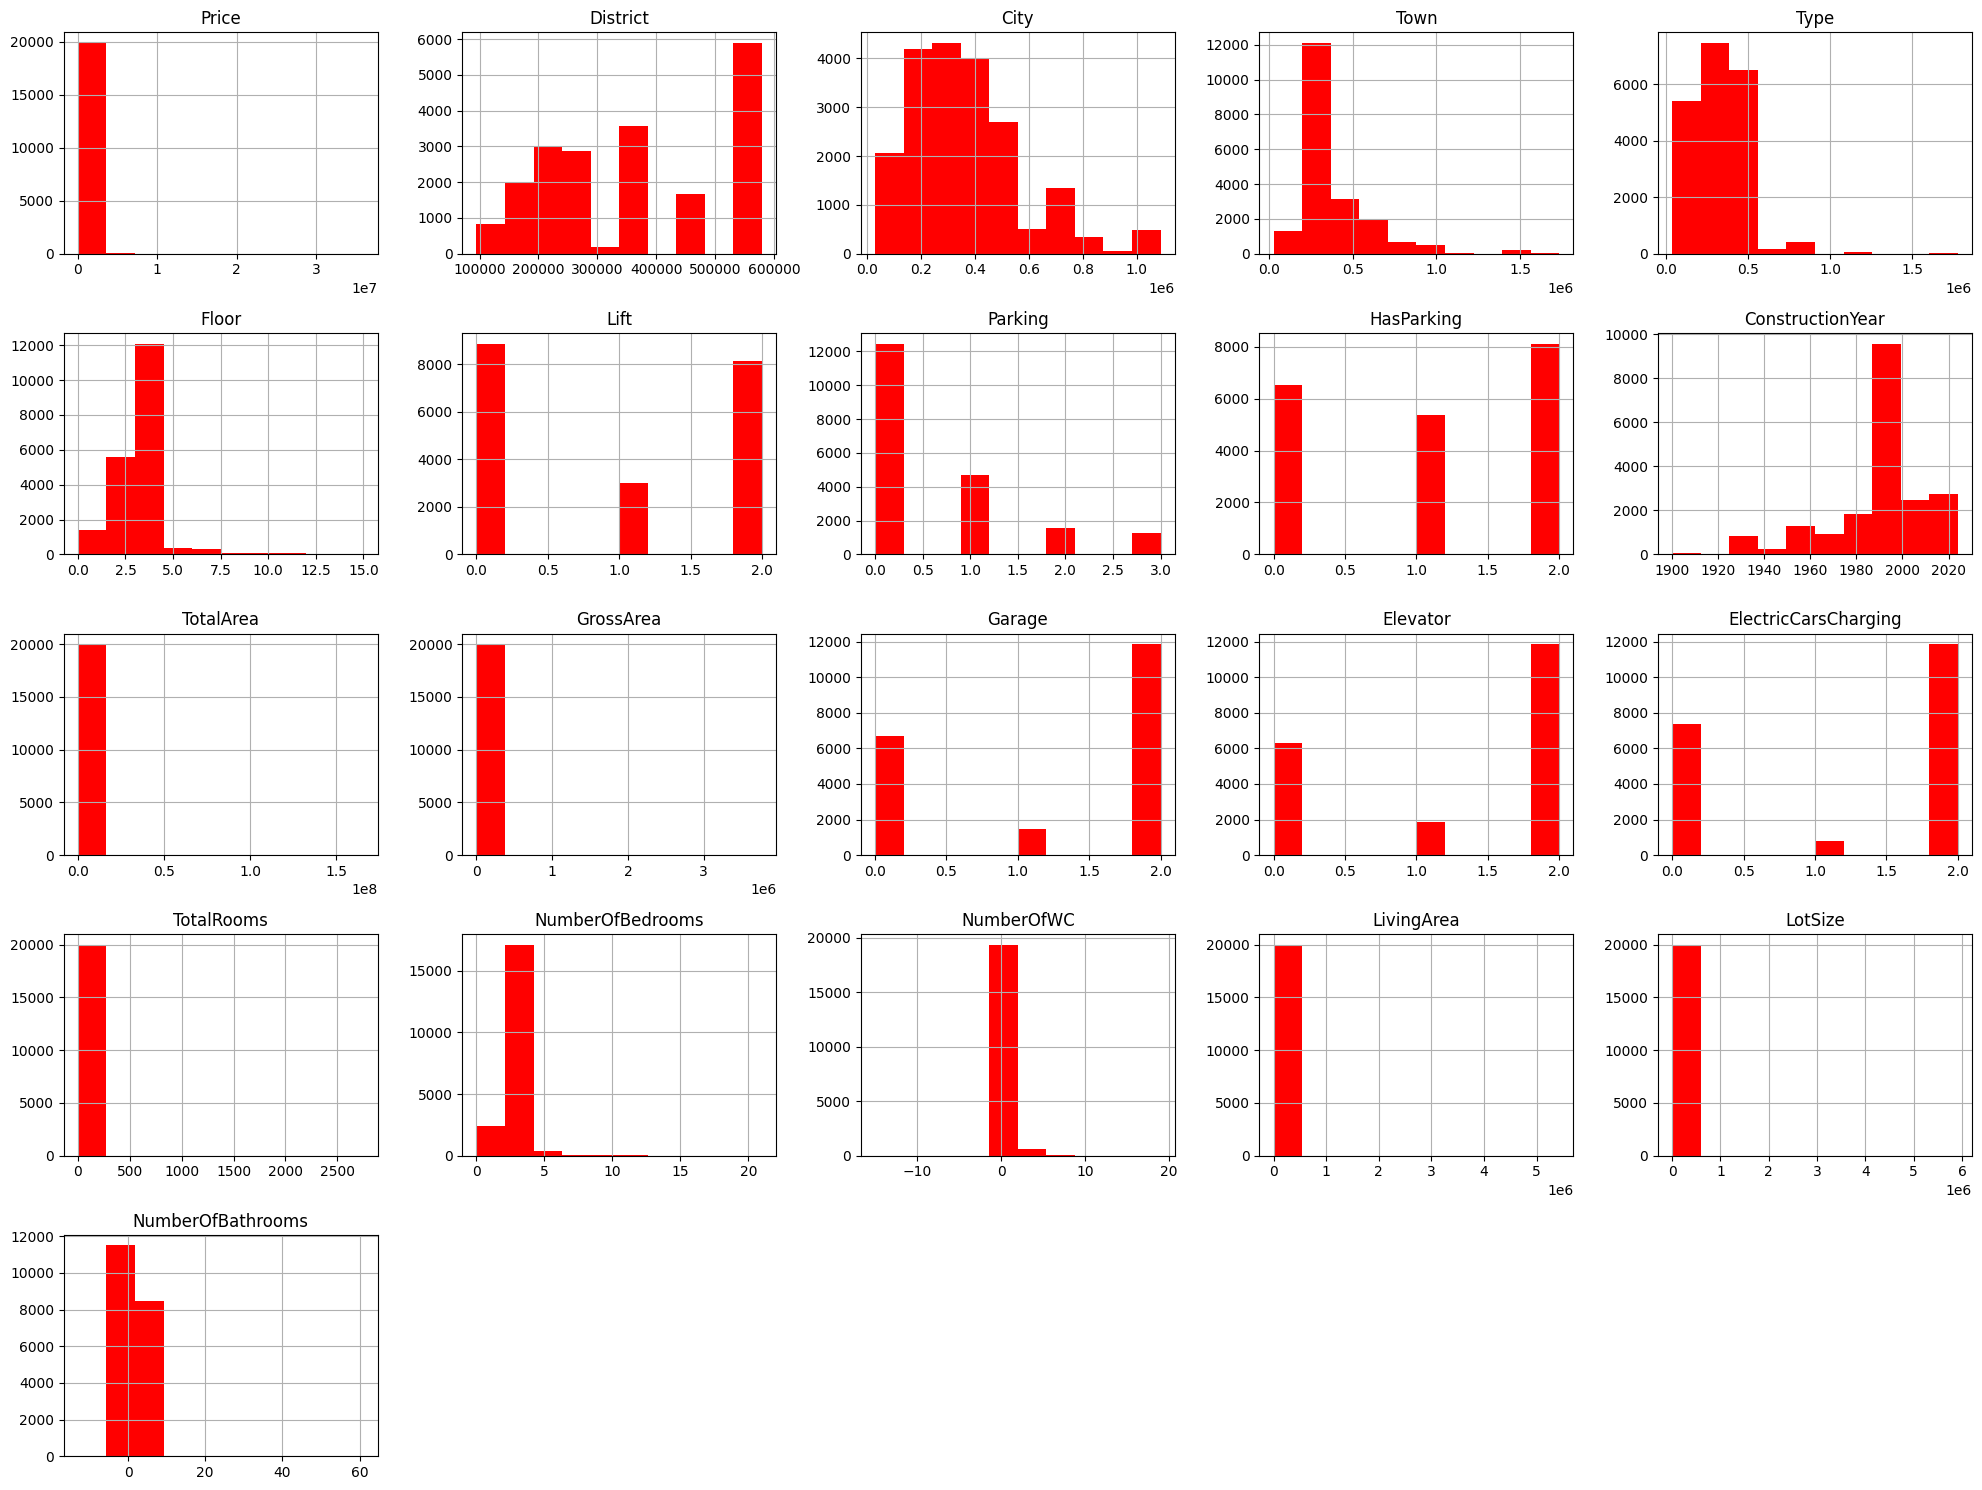

In [30]:
df[viz_column].hist(figsize=(20, 15), color='red');
plt.tight_layout()
plt.show()

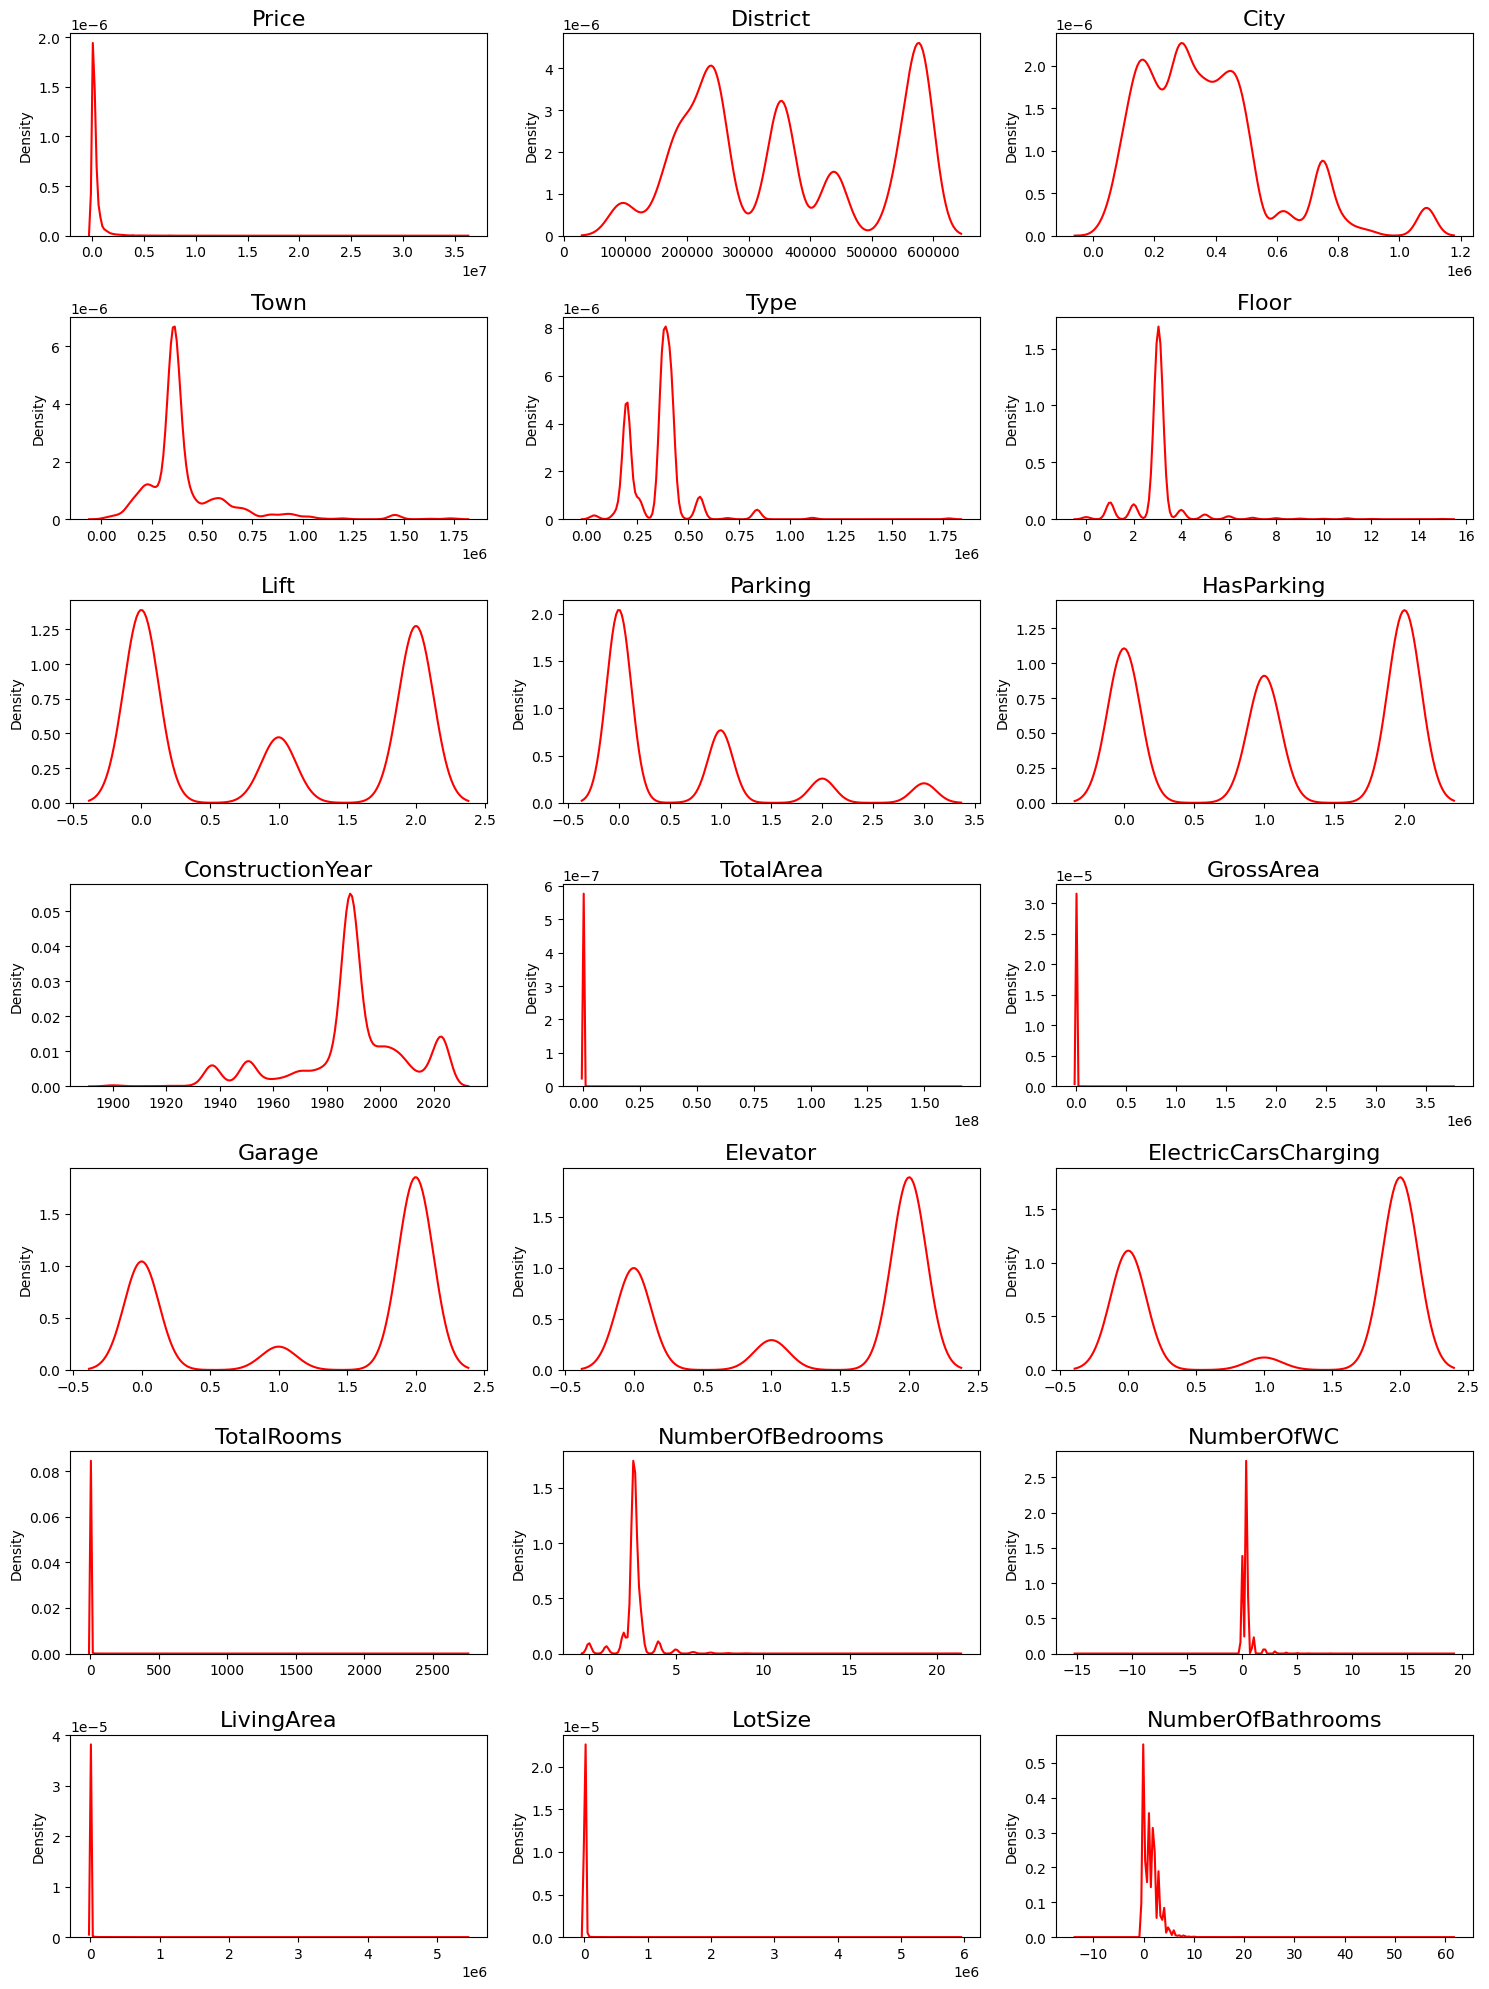

In [31]:
fig, ax = plt.subplots(7, 3, figsize=(15, 20))
ax = ax.flatten()

for i, col in enumerate(viz_column):
    sns.kdeplot(data=df, x=df[col], ax=ax[i], color='red')
    ax[i].set_title(col, fontsize=16)
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

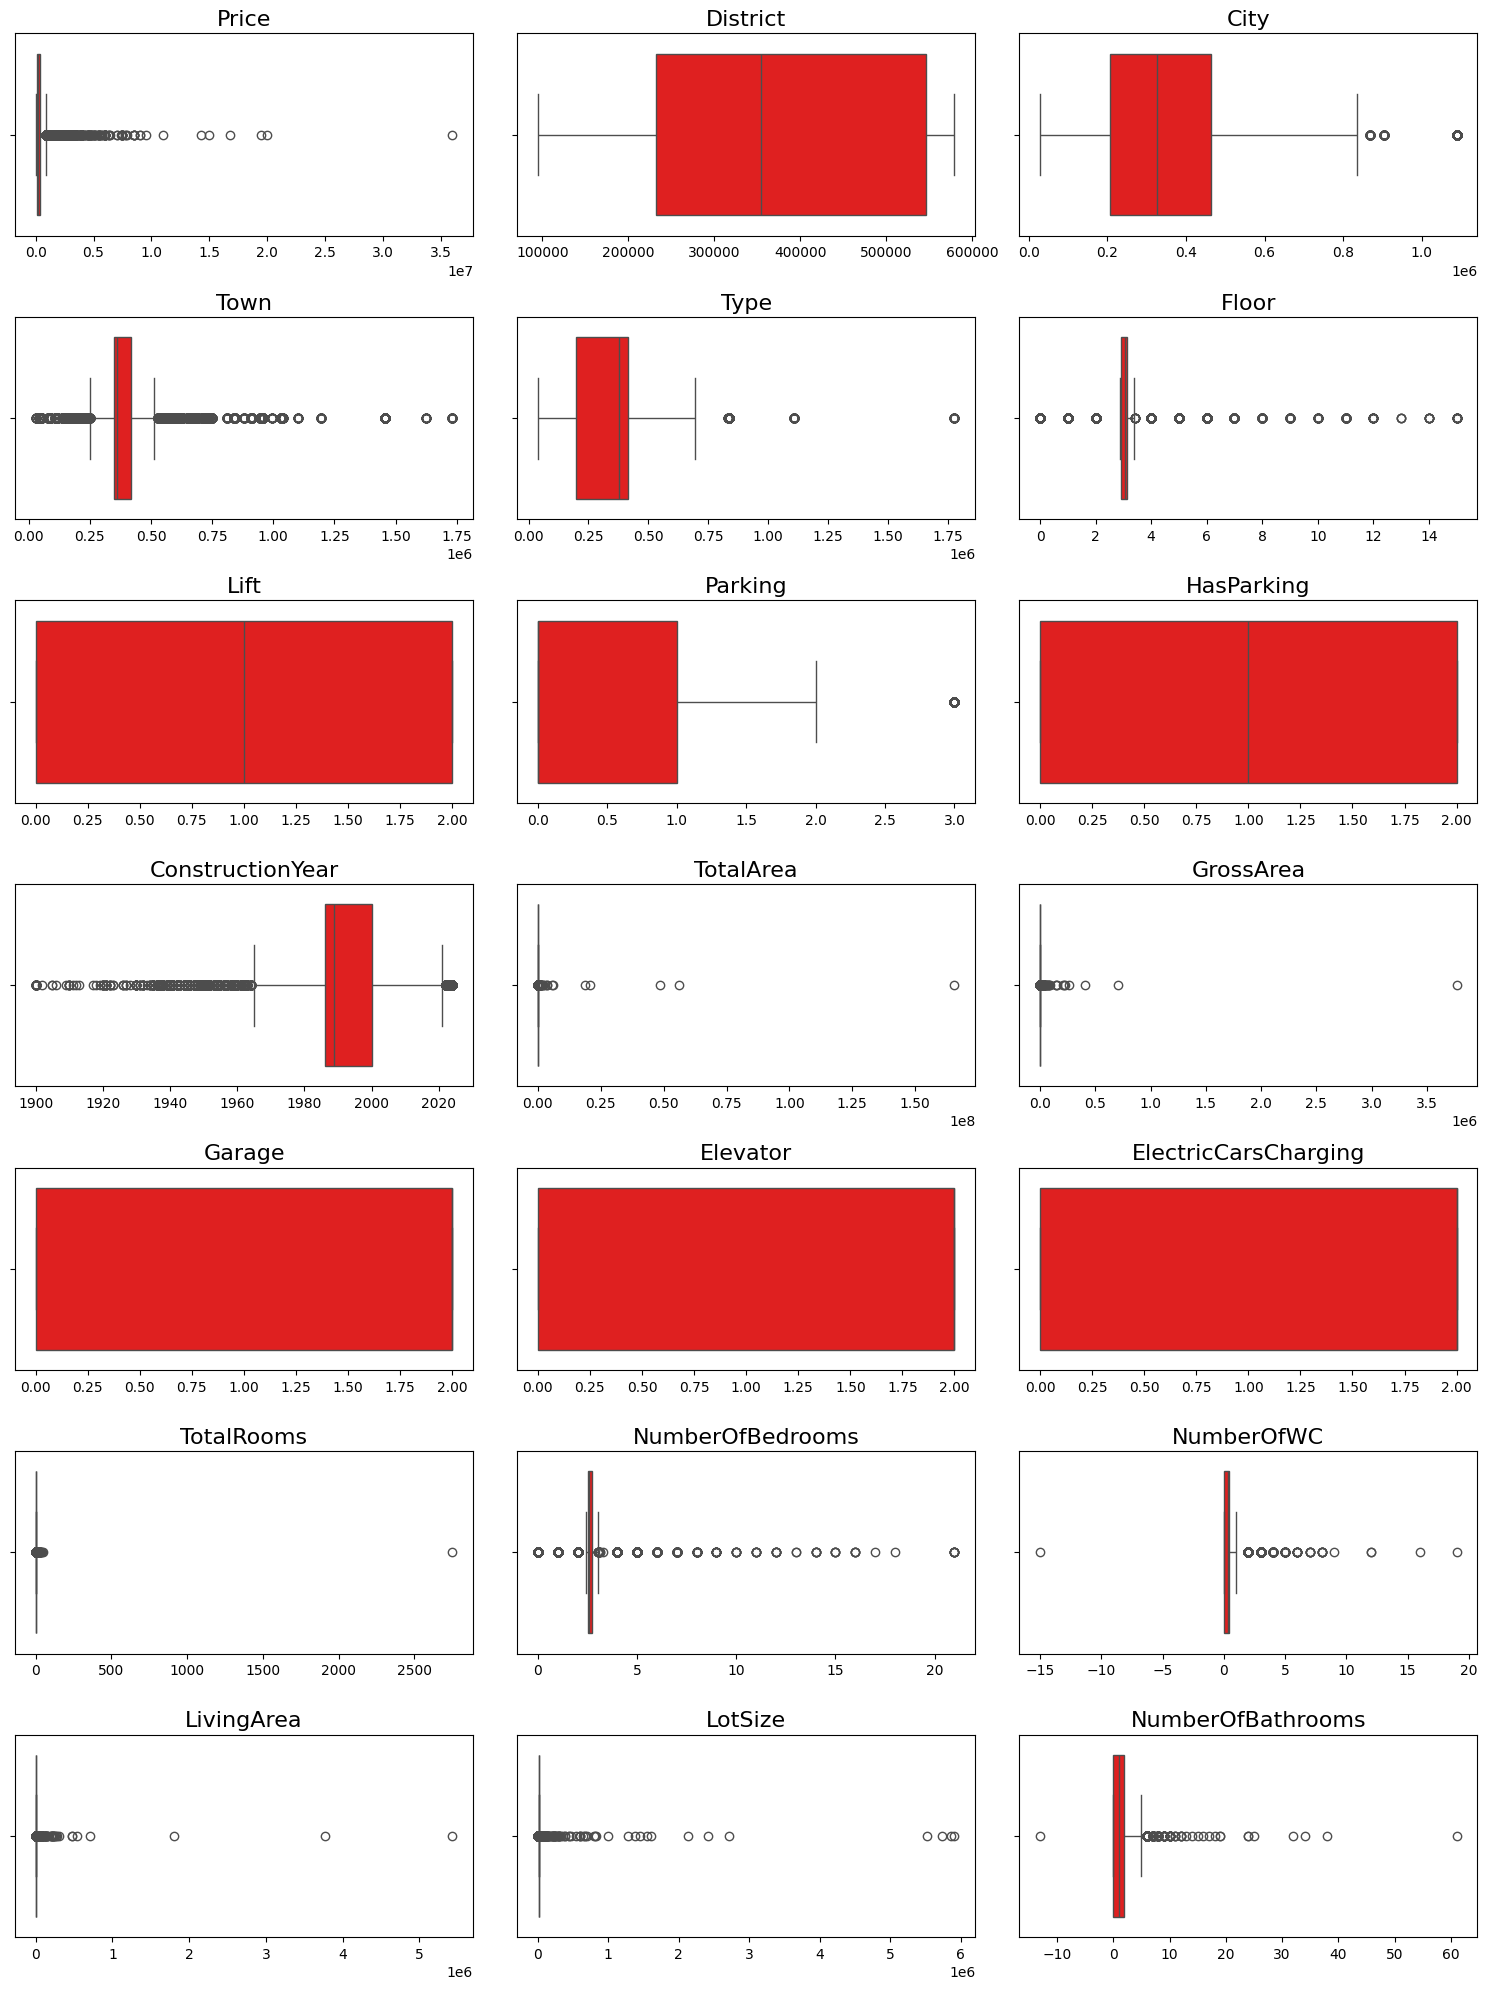

In [32]:
fig, ax = plt.subplots(7, 3, figsize=(15, 20))
ax = ax.flatten()

for i, col in enumerate(viz_column):
    sns.boxplot(data=df, x=df[col], color='red', ax=ax[i])
    ax[i].set_title(col, fontsize=16)
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [33]:
for i in df.select_dtypes(include=[np.number]).columns:
    df[i] = winsorize(df[i], limits=(0.05, 0.05))

In [34]:
df.head()

,Price,District,City,Town,Type,Floor,Lift,Parking,HasParking,ConstructionYear,...,EnergyCertificate_A+,EnergyCertificate_B,EnergyCertificate_B-,EnergyCertificate_C,EnergyCertificate_D,EnergyCertificate_E,EnergyCertificate_F,EnergyCertificate_G,EnergyCertificate_NC,EnergyCertificate_nan
0,55000.0,182976.679530,181476.439216,360431.935990,198945.468485,2.890121,0.0,0.0,0.0,1988.610505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,289000.0,438320.075269,433717.454545,360431.935990,413449.025698,3.054137,0.0,2.0,1.0,1986.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,46500.0,579375.321059,383077.451923,507618.867925,198945.468485,3.070403,2.0,0.0,2.0,1988.128326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,203000.0,354395.628585,420628.237988,350485.967995,376538.433345,4.000000,1.0,1.0,1.0,1996.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,72500.0,246906.372279,175244.339623,193420.501695,198945.468485,3.043777,2.0,0.0,2.0,1988.311230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


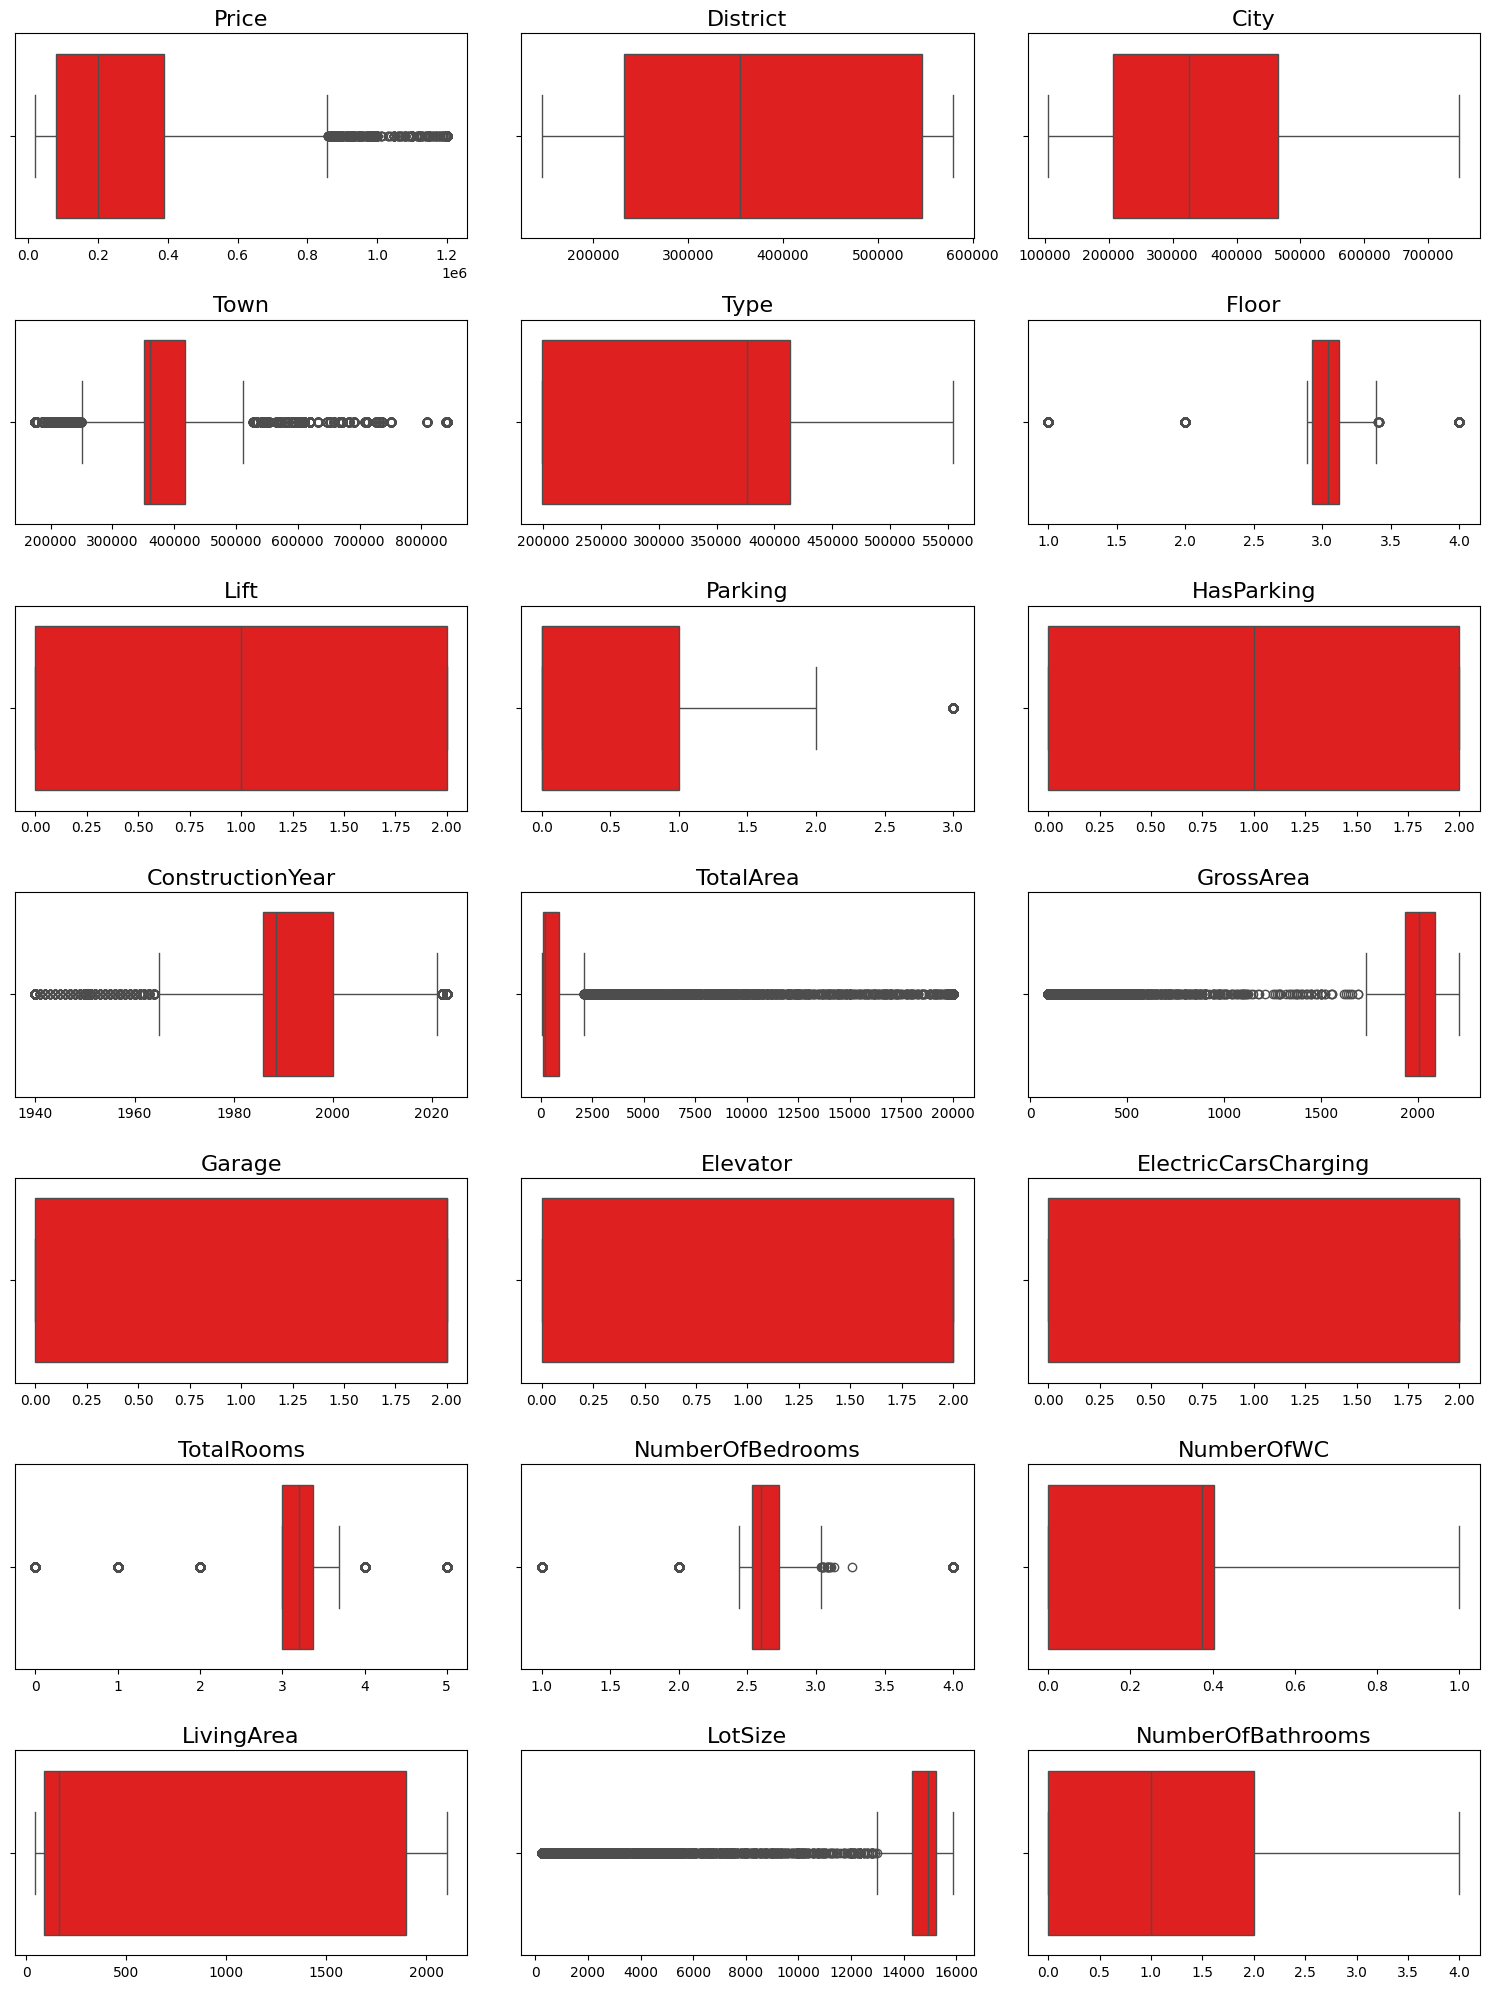

In [35]:
fig, ax = plt.subplots(7, 3, figsize=(15, 20))
ax = ax.flatten()

for i, col in enumerate(viz_column):
    sns.boxplot(data=df, x=df[col], color='red', ax=ax[i])
    ax[i].set_title(col, fontsize=16)
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

## Scaling Data

In [36]:
x = df.drop('Price', axis=1)
y = df['Price']

In [37]:
scaler = RobustScaler()

x_scaled = scaler.fit_transform(x)

In [38]:
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

## KFold Cross Validation

In [39]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train, test in kf.split(x_scaled):
    print(f"Train: {train}\t\tTest: {test}")

Train: [    0     1     2 ... 19996 19997 19999]		Test: [    3    17    31 ... 19980 19989 19998]
Train: [    1     2     3 ... 19997 19998 19999]		Test: [    0     6    19 ... 19969 19970 19991]
Train: [    0     1     2 ... 19997 19998 19999]		Test: [    5     8    14 ... 19987 19988 19990]
Train: [    0     1     2 ... 19997 19998 19999]		Test: [   15    20    27 ... 19961 19977 19995]
Train: [    0     1     2 ... 19997 19998 19999]		Test: [    7    23    36 ... 19960 19976 19996]
Train: [    0     1     2 ... 19997 19998 19999]		Test: [   10    12    21 ... 19973 19975 19993]
Train: [    0     2     3 ... 19997 19998 19999]		Test: [    1     4    18 ... 19959 19968 19984]
Train: [    0     1     2 ... 19997 19998 19999]		Test: [   44    52    66 ... 19952 19955 19994]
Train: [    0     1     3 ... 19997 19998 19999]		Test: [    2    16    24 ... 19979 19982 19992]
Train: [    0     1     2 ... 19995 19996 19998]		Test: [    9    11    13 ... 19986 19997 19999]


In [40]:
models = {'CatBoostRegressor':CatBoostRegressor(verbose=0), 'XGBRegressor':XGBRegressor(), 'LGBMRegressor':LGBMRegressor(verbose=0),
         'RandomForestRegressor':RandomForestRegressor()}

metrics_dict = {
    'model': [],
    'r2_score': [],
    'mae_score': [],
    'mse_score': [],
    'rmse_score': []
}

for nama, model in tqdm(models.items(), desc='Evaluation metrics: '):
    score = cross_validate(model, x_scaled, y, cv=kf, scoring=['r2', 'neg_mean_absolute_error',
                                                              'neg_mean_squared_error'])
    rmse = np.sqrt(-score['test_neg_mean_squared_error'])

    mae = score['test_neg_mean_absolute_error'].mean()
    mse = score['test_neg_mean_squared_error'].mean()
    r2 = score['test_r2'].mean()

    metrics_dict['model'].append(nama)    
    metrics_dict['mae_score'].append(mae.round(4))
    metrics_dict['mse_score'].append(mse.round(4))
    metrics_dict['r2_score'].append(r2.round(4))
    metrics_dict['rmse_score'].append(rmse.mean().round(4))

metrics_df = pd.DataFrame(metrics_dict)

Evaluation metrics: 100%|███████████████████████████████████████████████████████████████| 4/4 [08:00<00:00, 120.24s/it]


In [41]:
metrics_df

,model,r2_score,mae_score,mse_score,rmse_score
0,CatBoostRegressor,0.8521,-72703.3887,-1.393339e+10,118001.6147
1,XGBRegressor,0.8345,-76005.7811,-1.559107e+10,124816.1973
2,LGBMRegressor,0.8267,-78930.0444,-1.631427e+10,127670.1591
3,RandomForestRegressor,0.8154,-76018.4373,-1.738707e+10,131799.4879


## Hyperparameter Tunning

In [42]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 10, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 5, 10),
#         'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 5),
#         'random_seed': 42
#     }
#     model = CatBoostRegressor(**params, silent=True)
#     kf = KFold(n_splits=10, shuffle=True, random_state=42)
#     scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='r2')
#     return scores.mean()
    
# study = optuna.create_study(direction='maximize')    
# study.optimize(objective, n_trials=100)

# print(f"Best parameter: ")
# print(study.best_params)
# print(f"best f2_score accuracy: {study.best_value}")

In [43]:
# cat_model = CatBoostRegressor(**study.best_params, silent=True)

# cat_score = cross_validate(cat_model, x_scaled, y, cv=kf, scoring=['r2', 'neg_mean_absolute_error',
#                                                               'neg_mean_squared_error'])

In [44]:
# rmse = (np.sqrt(-score['test_neg_mean_squared_error'])).mean()
# mae = score['test_neg_mean_absolute_error'].mean()
# mse = score['test_neg_mean_squared_error'].mean()
# r2 = score['test_r2'].mean()

# print(f"mean_absolute_error    : {mae}")
# print(f"mean_squared_error     : {mse}")
# print(f"root_mean_squared_error: {rmse}")
# print(f"r2_score               : {r2*100:.3f}%")